<a href="https://colab.research.google.com/github/bondpy202212/AI_projects/blob/main/7_Multi_class_Classification(images_of_hands_of_the_english_alphabet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

**Dataset**

In [2]:
!kaggle datasets download -d datamunge/sign-language-mnist -q

!unzip sign-language-mnist.zip

Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


**Define the path for the training and validation files.**

In [3]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

**Take a look at how the data looks like within the csv file**

In [4]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

**Parsing the dataset**

In [5]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file

  Args:
    filename (string): path to the CSV file

  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    # Use csv.reader, passing in the appropriate delimiter
    # Remember that csv.reader can be iterated and returns one line in each iteration
    csv_reader = csv.reader(file, delimiter=',')
    next(csv_reader)

    data = []

    for row in csv_reader:
      label = float(row[0])
      image_pixels = [float(x) for x in row[1:]]

      image = np.array(image_pixels).reshape(28, 28)
      data.append((label, image))

    labels, images = zip(*data)

    labels = np.array(labels, dtype=np.float64)
    images = np.array(images, dtype=np.float64)


    return images, labels

Test "parse_data_from_input()" function

In [6]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


**Visualizing the numpy arrays**

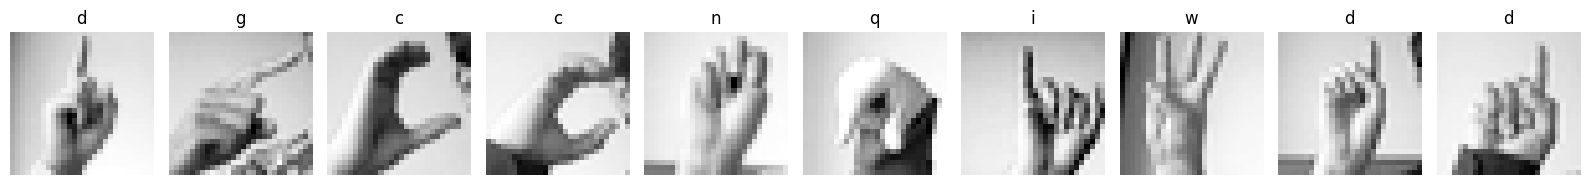

In [7]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

**Creating the generators for the CNN**

In [8]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  # In this section you will have to add another dimension to the data
  # So, for example, if your array is (10000, 28, 28)
  # You will need to make it (10000, 28, 28, 1)
  # Hint: np.expand_dims
  num = 26
  training_images = np.expand_dims(training_images, -1)
  validation_images = np.expand_dims(validation_images, -1)

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images ,
                                       y=tf.keras.utils.to_categorical(training_labels, num_classes=num),
                                       batch_size=32)


  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale = 1. / 255.)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=tf.keras.utils.to_categorical(validation_labels, num_classes=num),
                                                 batch_size=32)

  return train_generator, validation_generator

**Test generators**

In [9]:
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455, 26)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172, 26)


**Coding the CNN**

In [10]:
def create_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(26, activation='softmax')
  ])

  model.compile(optimizer = 'rmsprop',
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

  return model

**Save and train the model**

In [12]:
import warnings

warnings.filterwarnings('ignore')

In [13]:
# Save model
model = create_model()

# Train model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.5367 - loss: 1.5616 - val_accuracy: 0.9177 - val_loss: 0.2804
Epoch 2/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 78s 76ms/step - accuracy: 0.9855 - loss: 0.0514 - val_accuracy: 0.9308 - val_loss: 0.2079
Epoch 3/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 80s 74ms/step - accuracy: 0.9964 - loss: 0.0132 - val_accuracy: 0.9324 - val_loss: 0.2804
Epoch 4/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 85s 78ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9437 - val_loss: 0.3107
Epoch 5/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 62s 73ms/step - accuracy: 0.9988 - loss: 0.0047 - val_accuracy: 0.9307 - val_loss: 0.2941
Epoch 6/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 67s 78ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.9371 - val_loss: 0.3338
Epoch 7/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 78s 73ms/step - accuracy: 0.9997 - loss: 8.6044e-04 - val_accuracy: 0.9222 - val_loss: 0.4592
Epoch 8/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 81s 72ms/step - accuracy: 0.9997 - loss: 0.001

**Training history**

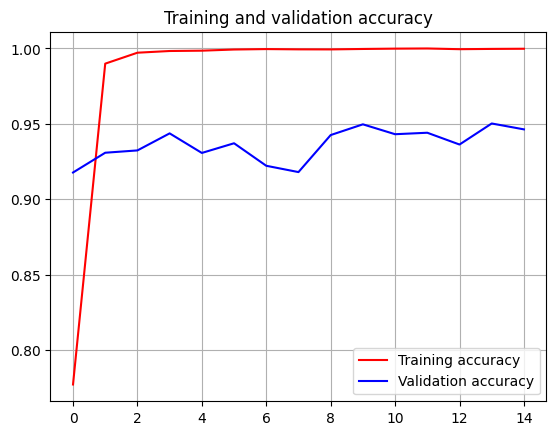

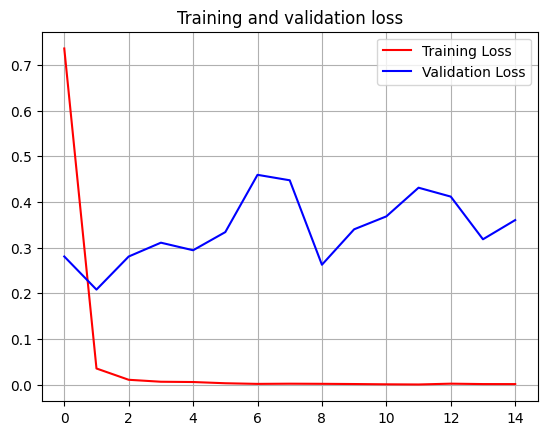

In [14]:
#  Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid(True)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)

plt.show()